# Figure 6 and 7: Transmission spectra

## Setup

In [1]:
%load_ext nb_black
%load_ext autoreload
%autoreload 2

<IPython.core.display.Javascript object>

In [2]:
import glob as glob
import matplotlib as mpl
import matplotlib.patheffects as PathEffects
import matplotlib.pyplot as plt
import matplotlib.transforms as transforms
import numpy as np
import pandas as pd
import seaborn as sns

import corner
import json
import pathlib
import pickle
import utils
import warnings

from astropy import constants as const
from astropy import units as uni
from astropy.io import ascii, fits
from astropy.time import Time
from mpl_toolkits.axes_grid1 import ImageGrid

# Default figure dimensions
FIG_WIDE = (11, 5)
FIG_LARGE = (8, 11)

# Figure style
sns.set(style="ticks", palette="colorblind", color_codes=True, context="talk")
params = {
    # xticks
    "xtick.top": False,
    "xtick.direction": "out",
    "xtick.major.size": 5,
    "xtick.minor.visible": False,
    # yticks
    "ytick.right": False,
    "ytick.direction": "out",
    "ytick.major.size": 5,
    "ytick.minor.visible": False,
    # pallete
    "axes.prop_cycle": mpl.cycler(
        color=[
            "#fdbf6f",  # Yellow
            "#ff7f00",  # Orange
            "#a6cee3",  # Cyan
            "#1f78b4",  # Blue
            "#956cb4",  # Purple
            "#029e73",  # Green
            "#c44e52",  # Red
        ]
    ),
}
plt.rcParams.update(params)

<IPython.core.display.Javascript object>

## Dowload data([Fig. 6](https://www.dropbox.com/sh/zy9aoqbnpo6s8am/AAASpJ2E9bJipz55U_6SFto_a?dl=1), [Fig. 7](https://www.dropbox.com/sh/2lbco4q48g8wjh8/AACwwwbTStiqtCujwzhIDw__a?dl=1))

This should be placed in a folder named `data` in the same level as this notebook

## Plot

offsets: [-360.38370533 -228.91794043  626.00316194  259.30348806 -113.60920387]
offsets (% mean wlc depth): [-2.78392137 -1.76836393  4.83580017  2.00308868 -0.87761762]
(5, 3, 17)
Saving tspec to: data/06/tspec_c.csv
mean WLC depth: 12945.182608127869 2.168930318004236
Rp (Rj): 1.2754725790428136 jupiterRad
Rs (Rsun): 1.152 solRad
gp (m/s^2): 2925.3276999709506 cm / s2


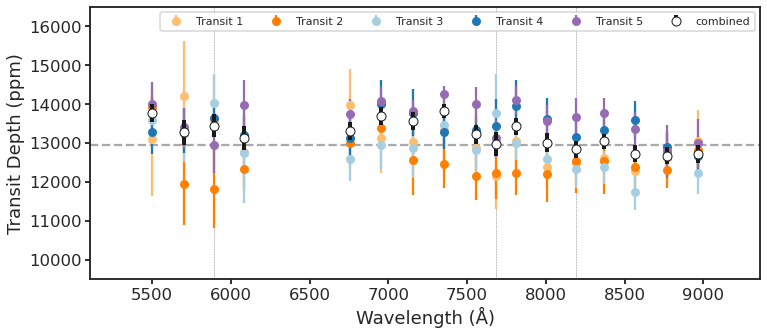

<IPython.core.display.Javascript object>

In [8]:
base_dir = "data/06"  # Change to 07 to produce Figure 7
data_dirs = sorted(glob.glob(f"{base_dir}/hp*"))
data_dict = {
    f"Transit {i}": data_dir for (i, data_dir) in enumerate(data_dirs, start=1)
}

# Use first entry for wavelength
transit_0, dirpath_0 = "Transit 1", data_dict["Transit 1"]
fpath = f"{dirpath_0}/transpec.csv"
df_wavs = pd.read_csv(fpath)[["Wav_d", "Wav_u"]]
wav = np.mean(df_wavs, axis=1)

depth_wlc_stats = []
tspec_stats = []
for transit, dirpath in data_dict.items():
    # WLCs
    fpath = f"{dirpath}/white-light/results.dat"
    results = pd.read_table(fpath, sep="\s+", escapechar="#", index_col="Variable")
    p, p_u, p_d = results.loc["p"]
    wlc_depth = p ** 2 * 1e6
    wlc_depth_u = p_u ** 2 * 1e6
    wlc_depth_d = p_d ** 2 * 1e6
    depth_wlc_stats.append([wlc_depth, wlc_depth_u, wlc_depth_d])

    # Tspec
    fpath = f"{dirpath}/transpec.csv"
    df_tspec = pd.read_csv(fpath)[["Depth (ppm)", "Depthup (ppm)", "DepthDown (ppm)"]]

    if (transit == "Transit 1" and "06" in dirpath) or ("07" in dirpath):
        tspec, tspec_u, tspec_d = df_tspec.values.T
    else:
        tspec, tspec_u, tspec_d = df_tspec.values[1:-1, :].T

    tspec_stats.append([tspec, tspec_u, tspec_d])

# Compute offset
depth_wlc_stats = np.array(depth_wlc_stats)
depth_wlc, depth_wlc_u, depth_wlc_d = depth_wlc_stats.T
mean_wlc_depth, mean_wlc_depth_unc = utils.weighted_mean_uneven_errors(
    depth_wlc, depth_wlc_u, depth_wlc_d
)

wlc_offsets = depth_wlc - mean_wlc_depth
# wlc_offsets *= 0
print(f"offsets: {wlc_offsets}")
print(f"offsets (% mean wlc depth): {wlc_offsets*100/mean_wlc_depth}")
tspec_stats = np.array(tspec_stats)  # transits x (depth, u, d) x wavelength
print(tspec_stats.shape)
tspec_stats[:, 0, :] -= wlc_offsets[np.newaxis].T

tspec_depths = tspec_stats[:, 0, :]
tspec_us = tspec_stats[:, 1, :]
tspec_ds = tspec_stats[:, 2, :]

######
# Plot
######
fig, ax = plt.subplots(figsize=FIG_WIDE)

ax.axhline(mean_wlc_depth, color="darkgrey", zorder=0, ls="--")

# Species
species = {
    "Na I-D": 5892.9,
    # "Hα":6564.6,
    "K I_avg": 7682.0,
    "Na I-8200_avg": 8189.0,
}
[
    ax.axvline(wav, ls="--", lw=0.5, color="grey", zorder=0)
    for name, wav in species.items()
]

tspec_tables = {}  # Each entry will hold Table(Transit, Depth, Up , Down)
# For combining into latex later
for transit, tspec, tspec_d, tspec_u in zip(
    data_dict.keys(), tspec_depths, tspec_ds, tspec_us
):
    ax.errorbar(
        wav,
        tspec,
        yerr=[tspec_d, tspec_u],
        fmt="o",
        alpha=1.0,
        mew=0,
        label=transit,
        barsabove=False,
    )

    data_i = {}
    data_i["Depth (ppm)"] = tspec
    data_i["Depthup (ppm)"] = tspec_u
    data_i["DepthDown (ppm)"] = tspec_d
    df = pd.DataFrame(data_i)
    tspec_tables[transit] = df

tspec_combined = []
tspec_combined_unc = []
tspec_combined_max = []
tspec_combined_unc_max = []
for i in range(len(tspec_stats[0, 0, :])):
    tspec_comb, tspec_comb_unc = utils.weighted_mean_uneven_errors(
        tspec_stats[:, 0, i], tspec_stats[:, 1, i], tspec_stats[:, 2, i]
    )
    tspec_combined.append(tspec_comb)
    tspec_combined_unc.append(tspec_comb_unc)

    # single errorbar way
    uncs_max = np.max([tspec_stats[:, 1, i], tspec_stats[:, 2, i]], axis=0)
    weights = 1 / uncs_max ** 2
    tspec_comb_max = np.average(tspec_stats[:, 0, i], weights=weights)
    tspec_comb_max_unc = utils.weighted_err(uncs_max)
    tspec_combined_max.append(tspec_comb_max)
    tspec_combined_unc_max.append(tspec_comb_max_unc)

# Combined
tspec_combined = np.array(tspec_combined)
tspec_combined_unc = np.array(tspec_combined_unc)
p = ax.errorbar(
    wav,
    tspec_combined,
    yerr=tspec_combined_unc,
    c="w",
    mec="k",
    fmt="o",
    zorder=10,
    label="combined",
    ecolor="k",
    lw=4,
)

# Write to table
tspec_table = pd.DataFrame()
tspec_table["Wavelength (Å)"] = df_wavs.apply(utils.write_latex_wav, axis=1)
# Transmission spectra
for transit, df_tspec in tspec_tables.items():
    tspec_table[transit] = df_tspec.apply(utils.write_latex_row, axis=1)
data = np.array([tspec_combined, tspec_combined_unc]).T
df_combined = pd.DataFrame(data, columns=["Combined", "Unc"])
tspec_table["Combined"] = df_combined.apply(utils.write_latex_single, axis=1)
# Save data
table_suffix = "c" if "06" in dirpath else "s"
out_path_tspec = f"{base_dir}/tspec_{table_suffix}.csv"
print(f"Saving tspec to: {out_path_tspec}")
tspec_table.to_csv(out_path_tspec, index=False)
np.savetxt(
    f"{base_dir}/tspec_{table_suffix}.txt",
    np.c_[wav, data],
    header="wav(Å) depth(ppm) depth_unc(ppm)",
),
np.savetxt(
    f"{base_dir}/mean_wlc_depth_{table_suffix}.txt",
    np.c_[mean_wlc_depth, mean_wlc_depth_unc],
    header="depth(ppm) depth_unc(ppm)",
)

ax.legend(loc=1, ncol=6, frameon=True, fontsize=11)
# Inset plots
if "07" in dirpath:
    margin = 10
    utils.plot_inset(
        ax,
        wav,
        tspec_combined,
        tspec_combined_unc,
        species,
        species_slc=slice(0, 5),
        box_lims=[0.3, 0.15, 0.2, 0.2],
        lims=(5780.40 - margin, 6005.40 + margin),
        mean_wlc_depth=mean_wlc_depth,
    )
    utils.plot_inset(
        ax,
        wav,
        tspec_combined,
        tspec_combined_unc,
        species,
        species_slc=slice(5, 10),
        box_lims=[0.38, 0.65, 0.2, 0.2],
        lims=(7657 - margin, 7707 + margin),
        mean_wlc_depth=mean_wlc_depth,
    )
    utils.plot_inset(
        ax,
        wav,
        tspec_combined,
        tspec_combined_unc,
        species,
        species_slc=slice(10, 15),
        box_lims=[0.78, 0.15, 0.2, 0.2],
        lims=(8089 - margin, 8289 + margin),
        mean_wlc_depth=mean_wlc_depth,
    )

# Save
ax.set_xlim(5106.55, 9362.45)
ax.set_ylim(9_500, 16_500)
ax.set_xlabel("Wavelength (Å)")
ax.set_ylabel(r"Transit Depth (ppm)")
fig.tight_layout()
fig.set_size_inches(FIG_WIDE)

print("mean WLC depth:", mean_wlc_depth, mean_wlc_depth_unc)
Rs = 1.152 * uni.solRad
Rp = np.sqrt(mean_wlc_depth * 1e-6 * Rs ** 2)
Mp = 1.92 * uni.jupiterMass
gp = const.G * Mp / Rp ** 2
print("Rp (Rj):", Rp.to("Rjupiter"))
print("Rs (Rsun):", Rs.to("Rsun"))
print("gp (m/s^2):", gp.to("cm/s^2"))

utils.savefig(f"../paper/figures/tspec/tspec_{table_suffix}.pdf")

[Other notebooks](https://icweaver.github.io/HAT-P-23b/)